### Objective: To develop and test functions for performing initial analysis of trajectories. 

I am going to test and compare MDTraj/MDTraj/pytraj.

In [61]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, GRO, XTC
import mdtraj as md
import pytraj as pt
import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Bio.SeqUtils import seq1
from mdakit_sasa.analysis.sasaanalysis import SASAAnalysis
import scipy as sp


import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

from vir_md_analysis.utils import ls
from vir_md_analysis.features.structural_features import *

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_dir = Path().cwd().parent.parent / 'vir_md_analysis' / 'data'

### Download test trajectories.

To develop and test function, I am downloading the dcd and psf files neutralizing antibodies in complex with the receptor binding domain of SARS-CoV-2 spike protein. This data set is from the following paper: 

Ray, D., Quijano, R. N., & Andricioaei, I. (2022). Simulation of Receptor Binding Domain of SARS-CoV-2 spike protein (WT and variants) in complex with neutralizing antibodies. (Version 1) [Data set]. [Zenodo](https://doi.org/10.5281/zenodo.6558396)



```bash
# Download the data set from Zenodo
!wget -O "{data_dir}/alpha_RBD_B38.psf" "https://zenodo.org/records/6558396/files/alpha_RBD_B38.psf?download=1"
!wget -O "{data_dir}/alpha_RBD_B38_500ns.dcd" "https://zenodo.org/records/6558396/files/alpha_RBD_B38_500ns.dcd?download=1"
```

### List data 

In [5]:

print(f'Data dir exists: {data_dir.exists()}')
ls(data_dir)

Data dir exists: True


['8md_prod.info',
 '8md_prod.rst',
 '8md_prod.out',
 '8md_prod.nc',
 'MAbFv.parm7',
 'alpha_RBD_B38.psf',
 'README.md',
 'MAbFv.parm7.hmass.parm7',
 '4md.nc',
 'alpha_RBD_B38_500ns.dcd',
 'prep4.pdb',
 'look_and_say.dat',
 '2md.nc',
 '3md.nc']

#### Use the demo trajectory for now. 

In [6]:

dcd = data_dir/'alpha_RBD_B38_500ns.dcd'
psf = data_dir/'alpha_RBD_B38.psf'
u = mda.Universe(psf, dcd)
protein = u.select_atoms('protein')
view = nv.show_mdanalysis(protein)
view

NGLWidget(max_frame=4978)

#### MD analysis to compute radius of gyration: 

Below I am computing the radius of gyration for the protein and backbone regions of the trajectory.
For the entire protein, I am using the code in the cell. For the backbone, I call the function `calculate_rg_for_specific_region` which is defined in `vir_md_analysis.features.structural_features.py` file.

In [7]:
def calculate_rg_for_specific_region(u: mda.Universe, region: str = 'protein',
                                     region_name: str = 'protein') -> pd.DataFrame:
    """Selects a region of a universe and calculate radius of gyration

    Args:
        u (md.Universe): The universe object to analyze.
        region (str, optional): The region to select in MD Analysis selection language.
                                 Defaults to 'protein'.
        region_name (str, optional): The name of the region. Defaults to 'protein'.

    Returns:
        pd.DataFrame: dataframe with radius of gyration data
    """

    region = u.select_atoms(region)
    frames = []
    times = []
    radii = []

    for ts in u.trajectory:
        frames.append(ts.frame)
        times.append(u.trajectory.time)
        radii.append(region.radius_of_gyration())

    df = pd.DataFrame({
        'Frame': frames,
        'Time (ns)': times,
        'Radius of Gyration (A)': radii
    })
    df.insert(0, 'Region', region_name)

    return df

CPU times: user 3.26 s, sys: 314 ms, total: 3.58 s
Wall time: 3.66 s


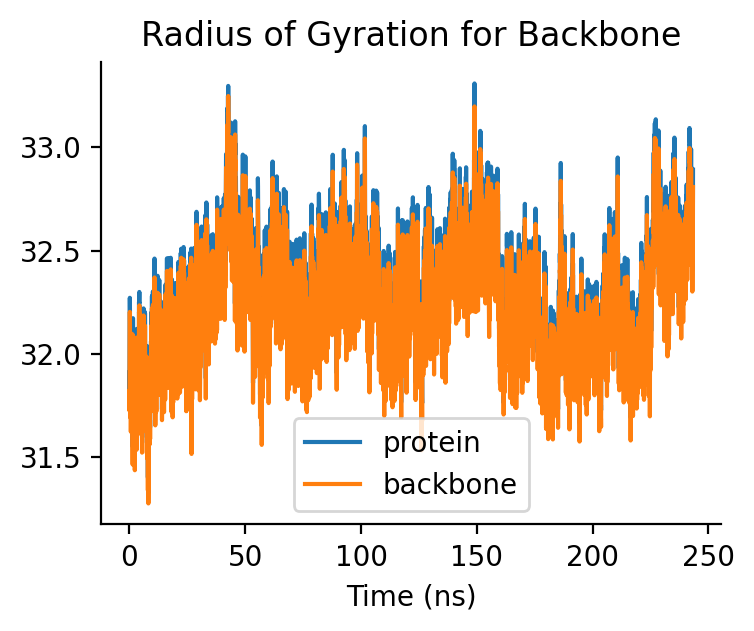

In [8]:
%%time
rad_gy=[]
time = []
frame =[]

for ts in u.trajectory: 
    time.append(u.trajectory.time)
    rad_gy.append(protein.radius_of_gyration())
    frame.append(ts.frame)

rg_df = pd.DataFrame({'Frame' : frame, 'Time (ns)': time, 
                     'radius of gyration A':rad_gy})
ax= rg_df.plot(x='Time (ns)', y= 'radius of gyration A', label = 'protein', 
               figsize=(4, 3))

rg_backbone_df = calculate_rg_for_specific_region(u, region = 'backbone')
rg_backbone_df.plot(x='Time (ns)', y= 'Radius of Gyration (A)', 
                    title='Radius of Gyration for Backbone', label = 'backbone', ax= ax)
sns.despine()


In [9]:
%timeit rg_backbone_df = calculate_rg_for_specific_region(u, region = 'backbone')

1.12 s ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Analysis using MDTraj

I am doing basically the same analysis as above but using MDTraj. I am using the same trajectory and psf files. It seems that MDTraj is significantly faster than MDAnalysis. 

In [10]:
traj = md.load_dcd(dcd, top=psf)

CPU times: user 2.82 s, sys: 911 ms, total: 3.73 s
Wall time: 3.91 s


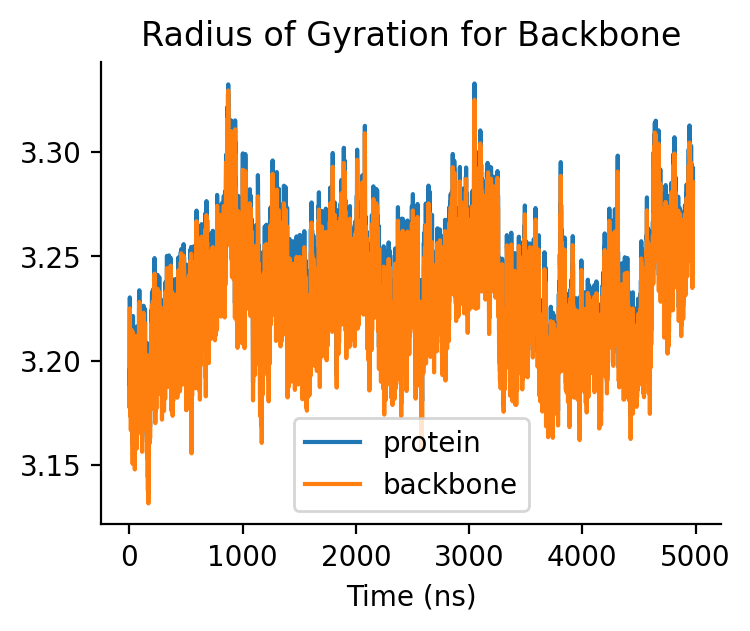

In [12]:
%%time
rg1_df = compute_radius_of_gyration_by_region(traj, region = 'protein')


ax= rg1_df.plot(x='Time (ns)', y= 'Radius of Gyration (A)', label = 'protein', 
               figsize=(4, 3))

rg_backbone_df =compute_radius_of_gyration_by_region(traj, region = 'backbone')
rg_backbone_df.plot(x='Time (ns)', y= 'Radius of Gyration (A)', 
                    title='Radius of Gyration for Backbone', label = 'backbone', ax= ax)
sns.despine()


In [16]:
%timeit rg_backbone_df =compute_radius_of_gyration_by_region(traj, region = 'backbone')

568 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Solvent accessible surface area

I will first write this code for mdtraj and then may be for MDAnalysis. It does not seem that mdanalysis has it directly implemented. I will check the documentation.

```python

def select_mdtraj_atoms(traj, region='protein'):
    """
    Select atoms from a trajectory based on a selection string.

    Parameters
    ----------
    traj : mdtraj.Trajectory
        The trajectory object.
    region : str
        The selection string for atoms to include in the SASA calculation.


    Returns
    -------
    traj_atoms: md.Trajectory
        A trajectory object containing the selected atoms.
    """
    # Select atoms based on the region string
    atoms = traj.topology.select(region)
    return traj.atom_slice(atoms)


def compute_sasa(traj, region_map: pd.DataFrame = None, chains: list[str] = None,
                 relative: bool = False):
    """
    Compute the solvent accessible surface area (SASA) of a trajectory.

    Parameters
    ----------
    traj : mdtraj.Trajectory
        The trajectory object.
    region_map : pd.DataFrame
        A DataFrame containing the regions of interest for the SASA calculation.
    chains : list[str]
        A list of chain IDs to include in the SASA calculation.
        If None, all chains will be included.

    Returns
    -------
    sasa_df: pandas.DataFrame
        A DataFrame containing the SASA values for each frame in the trajectory.
    """

    if chains:
        # Select atoms based on the chain IDs
        region = ' or '.join([f'chainid {chainid}' for chainid in chains])
        traj = select_mdtraj_atoms(traj, region=region)

    results = md.shrake_rupley(traj, get_mapping=True, mode='residue')
    sasa_df = pd.DataFrame(results[0], columns=traj.topology.residues)

    if relative:
        aminos = [seq1(residue.name) for residue in traj.topology.residues]
        for aa, col in zip(aminos, sasa_df.columns):
            sasa_df[col] /= (max_aa_sasa[aa]/100)

    if region_map is not None:
        # Map the SASA values to the regions
        region_map = region_map.set_index('residue')
        sasa_df = pd.DataFrame(sasa_df, columns=region_map.index)
        sasa_df = sasa_df.rename(columns=region_map.to_dict())

    return sasa_df, results[1]
```

#### Compute the SASA for the antibody on only 100 frames of the trajectoey

In [17]:
traj1 = select_mdtraj_atoms(traj, region='chainid 1 or chainid 2')
view2 = nv.show_mdtraj(traj1)
view2.add_surface()
view2

NGLWidget(max_frame=4978)

In [53]:
sasa_df, residues = compute_sasa(traj1[:100], relative=False)

In [54]:
sasa_df.head()

,ASP195,GLU1,VAL2,GLN3,LEU4,VAL5,GLU6,SER7,GLY8,GLY9,GLY10,LEU11,VAL12,GLN13,PRO14,GLY15,GLY16,SER17,LEU18,ARG19,LEU20,SER21,CYS22,ALA23,ALA24,SER25,GLY26,PHE27,ILE28,VAL29,SER30,SER31,ASN32,TYR33,MET34,SER35,TRP36,VAL37,ARG38,GLN39,ALA40,PRO41,GLY42,LYS43,GLY44,LEU45,GLU46,TRP47,VAL48,SER49,VAL50,ILE51,TYR52,SER53,GLY54,GLY55,SER56,THR57,TYR58,TYR59,ALA60,ASP61,SER62,VAL63,LYS64,GLY65,ARG66,PHE67,THR68,ILE69,SER70,ARG71,HIS72,ASN73,SER74,LYS75,ASN76,THR77,LEU78,TYR79,LEU80,GLN81,MET82,ASN83,SER84,LEU85,ARG86,ALA87,GLU88,ASP89,THR90,ALA91,VAL92,TYR93,TYR94,CYS95,ALA96,ARG97,GLU98,ALA99,TYR100,GLY101,MET102,ASP103,VAL104,TRP105,GLY106,GLN107,GLY108,THR109,THR110,VAL111,THR112,VAL113,SER114,SER115,ALA116,SER117,THR118,LYS119,GLY120,PRO121,SER122,VAL123,PHE124,PRO125,LEU126,ALA127,PRO128,SER129,SER130,LYS131,SER132,THR133,SER134,GLY135,GLY136,THR137,ALA138,ALA139,LEU140,GLY141,CYS142,LEU143,VAL144,LYS145,ASP146,TYR147,PHE148,PRO149,GLU150,PRO151,VAL152,THR153,VAL154,SER155,TRP156,ASN157,SER158,GLY159,ALA160,LEU161,THR162,SER163,GLY164,VAL165,HIS166,THR167,PHE168,PRO169,ALA170,VAL171,LEU172,GLN173,SER174,SER175,GLY176,LEU177,TYR178,SER179,LEU180,SER181,SER182,VAL183,VAL184,THR185,VAL186,PRO187,SER188,SER189,SER190,LEU191,GLY192,THR193,GLN194,THR195,TYR196,ILE197,CYS198,ASN199,VAL200,ASN201,HIS202,LYS203,PRO204,SER205,ASN206,THR207,LYS208,VAL209,ASP210,LYS211,ARG212,VAL213,GLU214,PRO215,LYS216,SER217,ASP413,ASP1,ILE2,VAL3,MET4,THR5,GLN6,SER7,PRO8,SER9,PHE10,LEU11,SER12,ALA13,SER14,VAL15,GLY16,ASP17,ARG18,VAL19,THR20,ILE21,THR22,CYS23,ARG24,ALA25,SER26,GLN27,GLY28,ILE29,SER30,SER31,TYR32,LEU33,ALA34,TRP35,TYR36,GLN37,GLN38,LYS39,PRO40,GLY41,LYS42,ALA43,PRO44,LYS45,LEU46,LEU47,ILE48,TYR49,ALA50,ALA51,SER52,THR53,LEU54,GLN55,SER56,GLY57,VAL58,PRO59,SER60,ARG61,PHE62,SER63,GLY64,SER65,GLY66,SER67,GLY68,THR69,GLU70,PHE71,THR72,LEU73,THR74,ILE75,SER76,SER77,LEU78,GLN79,PRO80,GLU81,ASP82,PHE83,ALA84,THR85,TYR86,TYR87,CYS88,GLN89,GLN90,LEU91,ASN92,SER93,TYR94,PRO95,PRO96,TYR97,THR98,PHE99,GLY100,GLN101,GLY102,THR103,LYS104,LEU105,GLU106,ILE107,LYS108,ARG109,THR110,VAL111,ALA112,ALA113,PRO114,SER115,VAL116,PHE117,ILE118,PHE119,PRO120,PRO121,SER122,ASP123,GLU124,GLN125,LEU126,LYS127,SER128,GLY129,THR130,ALA131,SER132,VAL133,VAL134,CYS135,LEU136,LEU137,ASN138,ASN139,PHE140,TYR141,PRO142,ARG143,GLU144,ALA145,LYS146,VAL147,GLN148,TRP149,LYS150,VAL151,ASP152,ASN153,ALA154,LEU155,GLN156,SER157,GLY158,ASN159,SER160,GLN161,GLU162,SER163,VAL164,THR165,GLU166,GLN167,ASP168,SER169,LYS170,ASP171,SER172,THR173,TYR174,SER175,LEU176,SER177,SER178,THR179,LEU180,THR181,LEU182,SER183,LYS184,ALA185,ASP186,TYR187,GLU188,LYS189,HIS190,LYS191,VAL192,TYR193,ALA194,CYS195,GLU196,VAL197,THR198,HIS199,GLN200,GLY201,LEU202,SER203,SER204,PRO205,VAL206,THR207,LYS208,SER209,PHE210,ASN211,ARG212,GLY213,GLU214,CYS215
0,2.104271,1.384135,0.639410,0.985636,0.042474,0.888683,0.186460,0.628356,0.435490,0.233152,0.387690,0.608008,0.178425,1.247848,0.652432,0.573906,0.128816,0.703434,0.299013,1.469306,0.0,0.281514,0.000000,0.360046,0.073663,0.646041,0.715093,0.211955,1.023558,0.000000,0.572104,0.843684,0.198126,0.903185,0.000000e+00,0.000000e+00,0.0,0.0,0.066932,0.149289,0.257328,1.038384,0.840172,1.576915,0.118959,0.041296,0.739457,0.258012,0.000000e+00,0.0,0.000000,0.066418,0.534547,0.492040,0.857916,0.350370,0.633549,0.460181,0.752440,0.526831,0.078989,1.129908,0.636700,0.000000,1.350129,0.875701,0.377190,0.051341,0.687731,0.026786,0.447430,0.531172,0.874795,0.690677,1.133114,1.606418,0.294564,0.069381,8.848819e-04,0.480852,0.0,0.362309,0.0,0.609981,0.642601,0.046876,1.205320,0.623005,1.208247,1.227713e-02,0.428053,0.009734,0.290485,0.0,0.045640,0.0,0.0,0.519943,0.241572,0.433608,1.518471,0.000885,0.000000e+00,0.284148,0.226391,0.253854,0.014509,1.305438,0.191847,0.199214,0.648159,0.000000,0.298188,0.049109,0.287182,1.113222,0.416815,0.896475,1.041880,1.205912,0.456430,0.201846,0.511487,0.036508,0.061760,0.225780,0.010619,0.267733,0.285804,0.510167,0.749686,2.196107,0.728225

In [55]:
residues

array([  0,   0,   0, ..., 433, 433, 433], shape=(6477,), dtype=int32)

In [56]:
sasa_corr = sasa_df.corr()
sasa_per_residue = sasa_df.aggregate(['mean', 'std'], axis=0).T
sasa_per_residue['Residue'] = pd.Series(sasa_per_residue.index).apply(lambda x: x.name).values

sasa_per_frame = sasa_df.aggregate(['mean', 'std'], axis=1).reset_index().rename(columns={'index': 'Frame'})
sasa_per_frame.head()

,Frame,mean,std
0,0,0.497072,0.474165
1,1,0.483850,0.462060
2,2,0.486904,0.463591
3,3,0.490164,0.460299
4,4,0.491205,0.464286


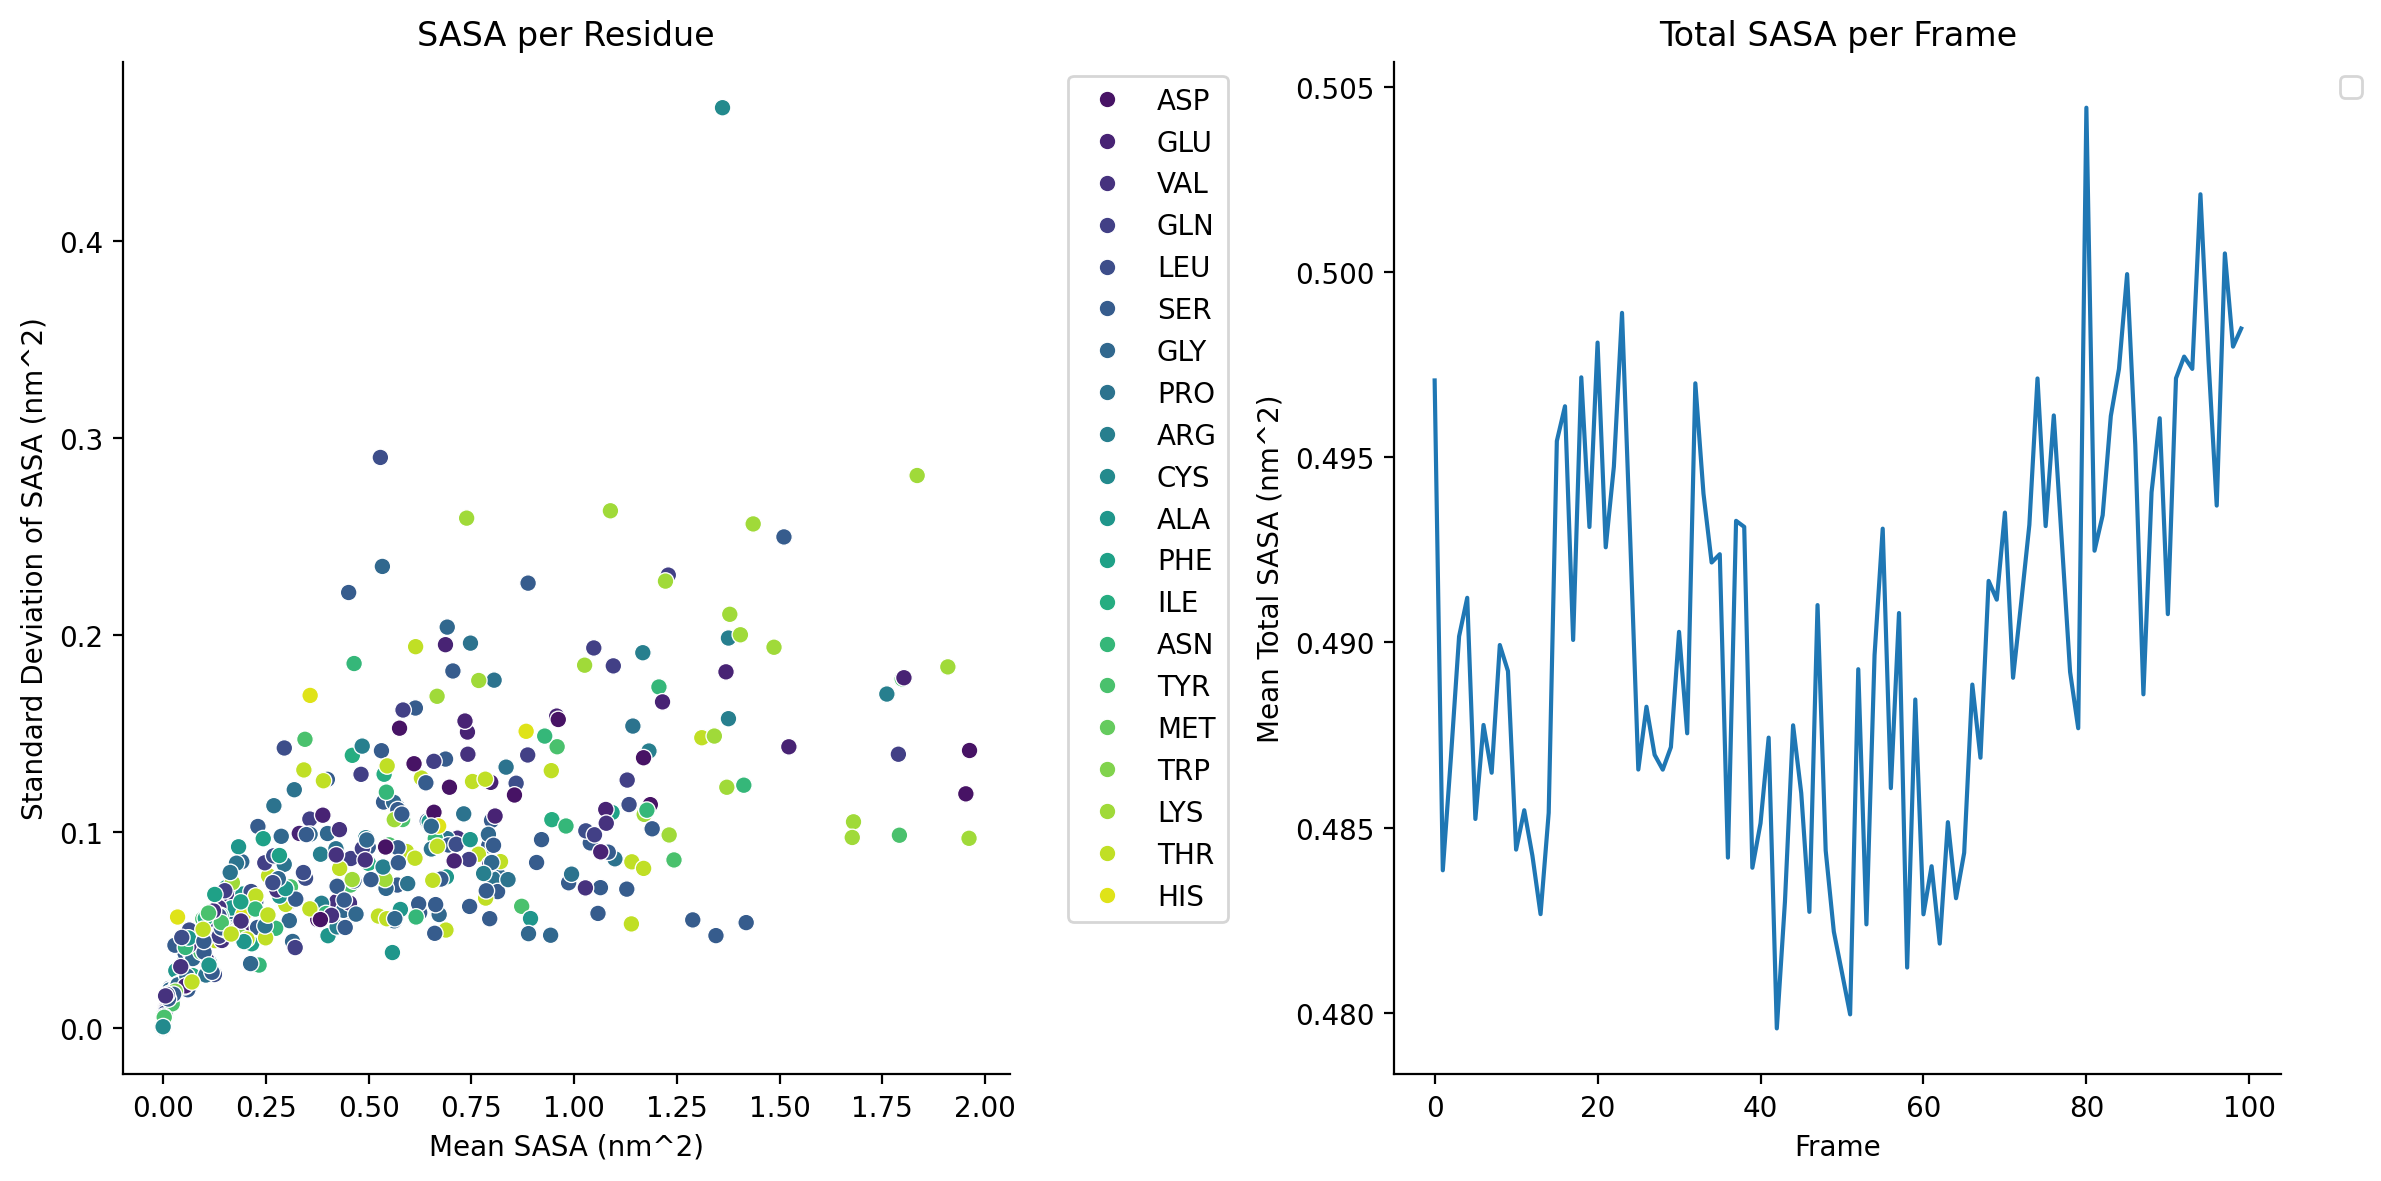

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax= sns.scatterplot(data=sasa_per_residue, x='mean', y='std', hue='Residue', palette='viridis', ax=axes[0])
ax.set_title('SASA per Residue')
ax.set_xlabel('Mean SASA (nm^2)')
ax.set_ylabel('Standard Deviation of SASA (nm^2)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax= sns.lineplot(data=sasa_per_frame, x='Frame', y='mean', palette='viridis', ax=axes[1])
ax.set_title('Total SASA per Frame')
ax.set_xlabel('Frame')
ax.set_ylabel('Mean Total SASA (nm^2)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine()
plt.tight_layout()

#### Use SASAAnalysis class from mdakit_sasa

In [58]:
# select atoms for the Fab region of the antibody
antibody = u.select_atoms('segid XP2 or segid XP3')
view = nv.show_mdanalysis(antibody)
view.add_surface()
view

NGLWidget(max_frame=4978)

#### Change the type of atom for the SASA calculation

The freesasa calculation is not working with the atom_types in the trajectory. I will change the atom types to the ones that freesasa can understand. 



```python 

atoms = list(u.atoms)
names = pd.Series([atom.name for atom in atoms]).value_counts()
types = pd.Series([atom.type for atom in atoms]).value_counts()

atom_table = mda.guesser.tables.atomelements
mass_table = mda.guesser.tables.masses

atom_map = {}
for atom_type in types.index:
    if atom_type in mass_table:
        atom_map[atom_type] = atom_type
    else:
        atom_map[atom_type] = atom_type[0]


for atom in u.atoms: 
    atom.type = atom_map[atom.type]

#u2 = mda.Universe( PSF, DCD, atom_residues=True)
sasa_analyzer = SASAAnalysis(u, selection = 'segid XP2 or segid XP3')
sasa_analyzer.run(start = 0, stop =20)
```

#### Comment: 
The SASAAnalysis class is much slower than the mdtraj.shrake_rupley function. So I will use the mdtraj function for SASA calculations for now. I may try pytraj later if needed.

### Number of Hydrogen Bonds. 

I am likley going to use the mdtraj version of the hydrogen bond analysis. I will first try to use the mdtraj function and then may be write my own function if needed.

There are two methods for this. Baker-Hubbard and Kabsh-Sander. Baker-Hubber uses geometry where as Kabsh-Sander uses energy function. 


As per the mdtraj documentation this function returns: 

`An array containing the indices atoms involved in each of the identified hydrogen bonds. Each row contains three integer indices, (d_i, h_i, a_i), such that d_i is the index of the donor atom, h_i the index of the hydrogen atom, and a_i the index of the acceptor atom involved in a hydrogen bond which occurs (according to the definition above) in proportion greater than freq of the trajectory.`

In [66]:
?md.baker_hubbard

Signature:
md.baker_hubbard(
    traj,
    freq=0.1,
    exclude_water=True,
    periodic=True,
    sidechain_only=False,
    distance_cutoff=0.25,
    angle_cutoff=120,
)
Docstring:
Identify hydrogen bonds based on cutoffs for the Donor-H...Acceptor
distance and angle.

The criterion employed is :math:`\theta > 120` and
:math:`r_\text{H...Acceptor} < 2.5 A`.

When donor the donor is 'N' and the acceptor is 'O', this corresponds to
the definition established in [1]_. The donors considered by this method
are NH and OH, and the acceptors considered are O and N.

Parameters
----------
traj : md.Trajectory
    An mdtraj trajectory. It must contain topology information.
freq : float, default=0.1
    Return only hydrogen bonds that occur in greater this fraction of the
    frames in the trajectory.
exclude_water : bool, default=True
    Exclude solvent molecules from consideration
periodic : bool, default=True
    Set to True to calculate displacements and angles across periodic box boundari

In [ ]:
T = 1000
hbonds_df = identify_hydrogen_bonds(traj1[:T], freq = 0.9)

In [63]:
hbonds_df.head()

,donor,hydrogen,acceptor,donor_element,donor_resSeq,donor_resName,donor_chainID,donor_segmentID,acceptor_element,acceptor_resSeq,acceptor_resName,acceptor_chainID,acceptor_segmentID
0,45,46,348,N,3,GLN,0,XP2,O,25,SER,0,XP2
1,81,82,327,N,5,VAL,0,XP2,O,23,ALA,0,XP2
2,97,98,109,N,6,GLU,0,XP2,O,6,GLU,0,XP2
3,112,113,307,N,7,SER,0,XP2,O,21,SER,0,XP2
4,137,138,1656,N,10,GLY,0,XP2,O,110,THR,0,XP2


In [65]:
(hbonds_df['donor_chainID'] != hbonds_df['acceptor_chainID']).sum()

np.int64(24)


```python

### Try with kabsh_sander 

This algorithm is based on the Kabsh-Sander definition. It computes the hydrogen bond energy between every carbonly oxygen and every nitrogen hydrogen. 
It is for the back bone atoms mostly. 

I can get the number of hydrogen bonds per time step. And also which residues are involved in the hydrogen bonds. 



In [68]:
T = 10000
results = md.kabsch_sander(traj1[:T])

In [71]:
num_hbonds_per_frame = calculate_number_of_hydrogen_bonds_per_frame(results)
num_hbonds_per_frame.head()

,Frame,Number of Hydrogen Bonds
0,0,277
1,1,267
2,2,269
3,3,267
4,4,279


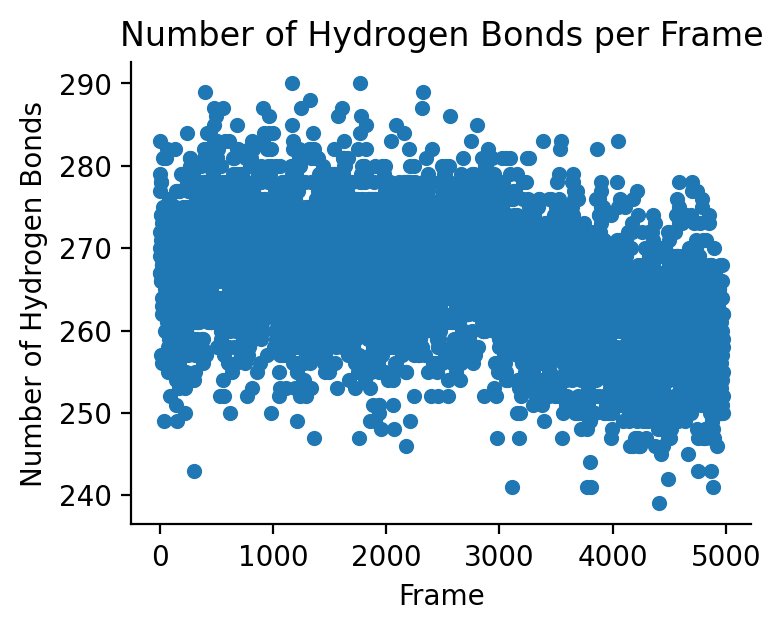

In [72]:
num_hbonds_per_frame.plot(kind='scatter', x='Frame', y='Number of Hydrogen Bonds',
                          title='Number of Hydrogen Bonds per Frame', figsize=(4, 3))
sns.despine()

In [73]:
topo = get_topology_dataframe(traj1, True)
hbonds_df = determine_residues_in_hydrogen_bonds(results, topology_df=topo)

In [74]:
hbonds_df.head()

,Acceptor,Donor,Mean Energy,Std Energy,Number Frames,Percent Frames,AcceptorResidue,DonorResidue
0,3,25,-1.877,0.0,4637,93.131,GLN,SER
1,5,23,-2.426,0.0,4974,99.900,VAL,ALA
2,7,21,-2.511,0.0,4972,99.859,SER,SER
3,10,112,-2.115,0.0,4904,98.494,GLY,THR
4,12,114,-2.083,0.0,4968,99.779,VAL,SER


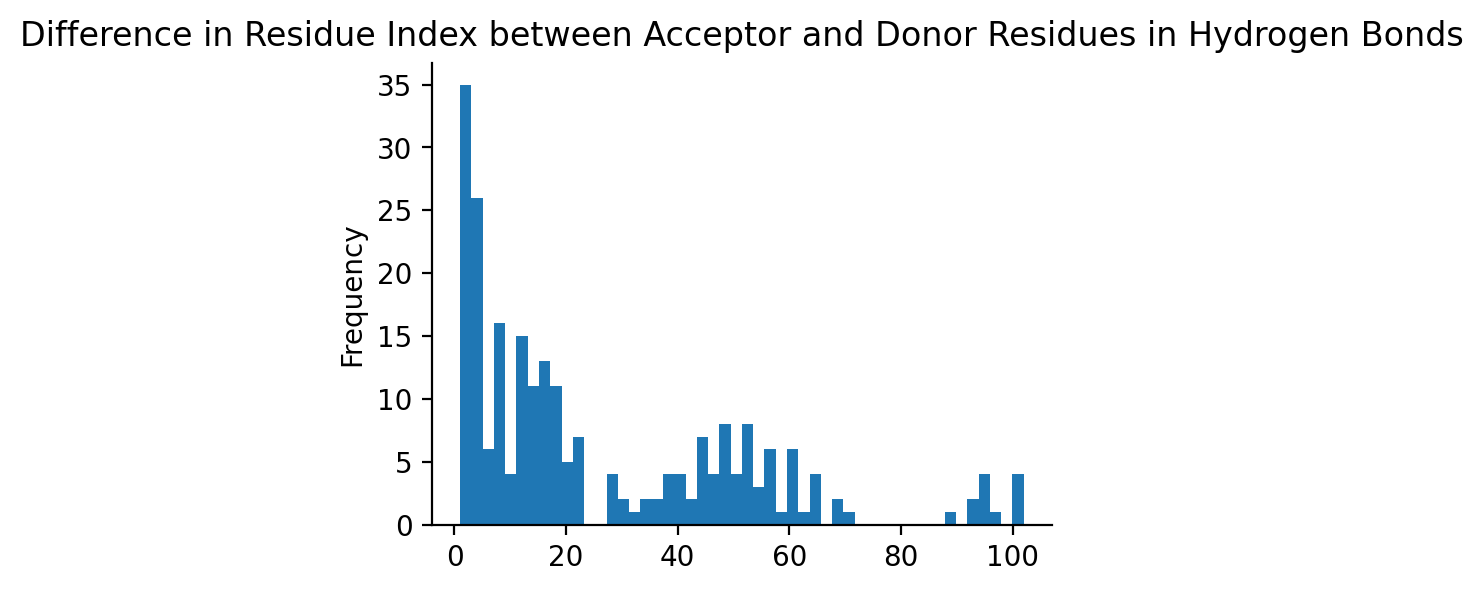

In [75]:
dist = (hbonds_df['Acceptor'] - hbonds_df['Donor']).abs()
dist.plot(kind='hist', bins=50, figsize=(4, 3),
          title='Difference in Residue Index between Acceptor and Donor Residues in Hydrogen Bonds')
sns.despine()

#### Now Wernet Nilsson
This method is similar to the the Baker-Hubbard method in that it is distance based. It uses a "cone" criterion where the distance cutoff depnends on the angle. 

The criterion employed is $𝑟_{\text{DA}}<3.3\text{𝐴}−0.00044\delta_{\text{𝐻𝐷𝐴}}^2$, where 𝑟DA is the distance between donor and acceptor heavy atoms, and $\delta_{\text{𝐻𝐷𝐴}}$ is the angle made by the hydrogen atom, donor, and acceptor atoms, measured in degrees (zero in the case of a perfectly straight bond: D-H … A).


In [79]:
T = 1000
hydrogens_wn = md.wernet_nilsson(traj1[:T], exclude_water=True, periodic=True, sidechain_only=False)

In [82]:
def wn_results_to_df(ws_results):
    dfs = []
    for res in ws_results:
        dfs.append(pd.DataFrame(res, columns=['donor', 'hydrogen', 'acceptor']))
    return dfs


def wn_results_to_contacts_by_frame_df(ws_results): 
    frame_dict = {}
    n = len(ws_results)
    for i, res in enumerate(ws_results):
        res = pd.DataFrame(res, columns=['donor', 'hydrogen', 'acceptor'])
        for row in res.itertuples(index=False):
            frame_dict.setdefault(row,[0]*n)
            frame_dict[row][i] += 1 
    df = pd.DataFrame.from_dict(frame_dict, orient='index')

    donor_hydrogen_acceptor = pd.DataFrame(dict(donor = pd.Series(df.index).apply(lambda x: x[0]),
                                           hydrogen = pd.Series(df.index).apply(lambda x: x[1]),
                                           acceptor = pd.Series(df.index).apply(lambda x: x[2])))

    contacts_by_frame_df = pd.concat([donor_hydrogen_acceptor, df.reset_index(drop=True)], axis=1)
    return contacts_by_frame_df.set_index(['donor', 'hydrogen', 'acceptor'])


def get_stable_hydrogen_bonds(hydrogens_df: pd.DataFrame, 
    topology_df: pd.DataFrame | None = None,
    threshold: float= 0.1) -> pd.DataFrame:
    """
    Get stable hydrogen bonds from the Wernet-Nilsson results.

    Parameters
    ----------
    hydrogens_df : pd.DataFrame
        DataFrame containing the hydrogen bond results.
    threshold : int, optional
        Minimum number of frames a hydrogen bond must be present to be considered stable, by default 10.

    Returns
    -------
    pd.DataFrame
        DataFrame containing stable hydrogen bonds.
    """
    fraction_frames = hydrogens_df.mean(axis=1)
    stable_hbonds = (fraction_frames[fraction_frames >= threshold]
                     .reset_index()
                     .rename(columns={0: 'Fraction Frames'})
                     )
                
    if topology_df is not None:
        stable_hbonds = merge_hydrogen_bonds_with_topology(stable_hbonds, topology_df)
        
    return stable_hbonds


hydrogens_wn_df = wn_results_to_df(hydrogens_wn)
hydrogens_wn_df[0].head()

,donor,hydrogen,acceptor
0,14,15,10
1,45,46,348
2,81,82,327
3,97,98,108
4,112,113,307


In [84]:
hydrogens_wn_by_frame_df=wn_results_to_contacts_by_frame_df(hydrogens_wn)
hydrogens_wn_by_frame_df

,,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,...,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
donor,hydrogen,acceptor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

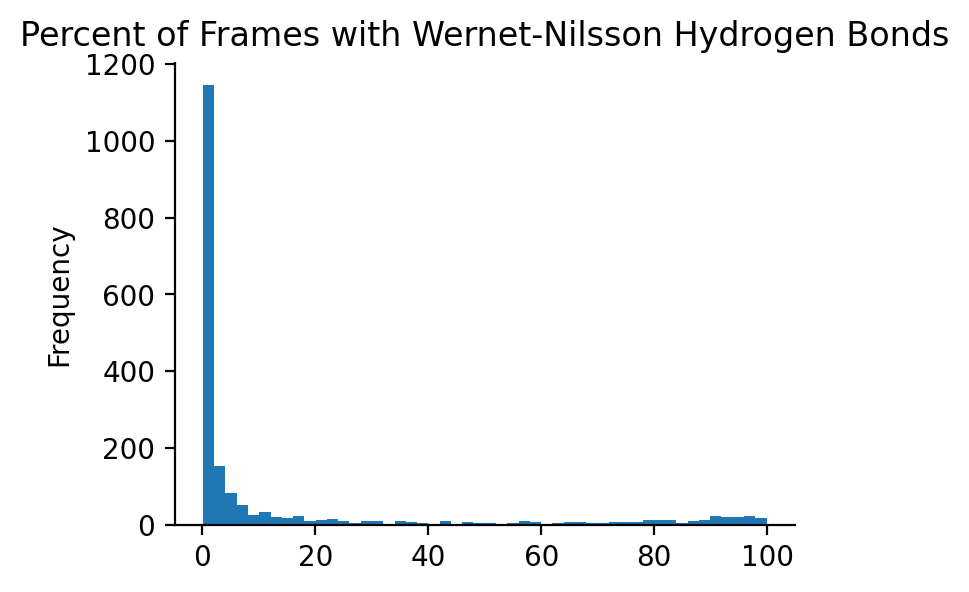

In [85]:
percent_frames =hydrogens_wn_by_frame_df.mean(axis = 1)*100
percent_frames.plot(kind='hist', bins=50, figsize=(4, 3),
                     title='Percent of Frames with Wernet-Nilsson Hydrogen Bonds')
sns.despine()

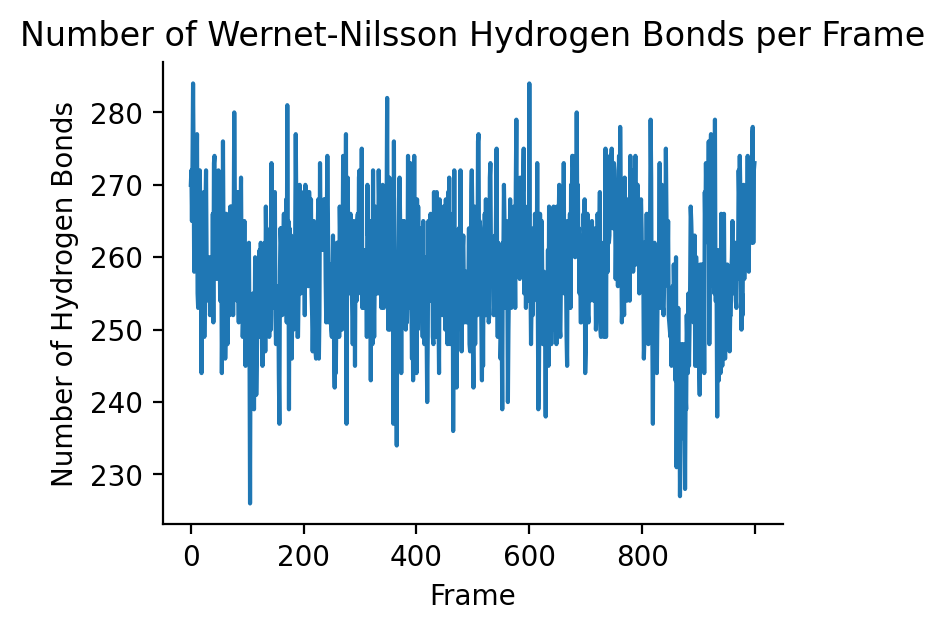

In [ ]:
num_hbonds_per_frame = hydrogens_wn_by_frame_df.sum(axis=0)
num_hbonds_per_frame.plot(kind='line', figsize=(4, 3), xlabel='Frame', ylabel='Number of Hydrogen Bonds',
                           title='Number of Wernet-Nilsson Hydrogen Bonds per Frame')
sns.despine()

In [88]:
topo = get_topology_dataframe(traj1, False)
get_stable_hydrogen_bonds(hydrogens_wn_by_frame_df,topology_df=topo, threshold=0.1).head()

,donor,hydrogen,acceptor,Fraction Frames,donor_element,donor_resSeq,donor_resName,donor_chainID,donor_segmentID,acceptor_element,acceptor_resSeq,acceptor_resName,acceptor_chainID,acceptor_segmentID
0,45,46,348,0.681,N,3,GLN,0,XP2,O,25,SER,0,XP2
1,81,82,327,0.654,N,5,VAL,0,XP2,O,23,ALA,0,XP2
2,112,113,307,0.885,N,7,SER,0,XP2,O,21,SER,0,XP2
3,137,138,1656,0.697,N,10,GLY,0,XP2,O,110,THR,0,XP2
4,163,164,1686,0.724,N,12,VAL,0,XP2,O,112,THR,0,XP2


#### Commment 
This is a very slow function,So I may consider not using it. 

I also need to decide how to integrate this into the code. Move on for now. 

### RMSD analysis

We will use the mdtraj.rmsd function to compute the RMSD of the trajectory. This function computes the RMSD of the trajectory with respect to a reference structure.

In [89]:
def compute_rmsd_on_specific_regions(traj: md.Trajectory, region: str | None ='backbone',
                                     parallel: bool = True, precentered: bool = False) -> pd.DataFrame:
    """
    Compute the root mean square deviation (RMSD) on specific regions of a trajectory.

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory object.
    region : str
        The selection string for atoms to include in the RMSD calculation.

    Returns
    -------
    rmsd_df: pandas.DataFrame
        A DataFrame containing the RMSD values for each frame in the trajectory.
    """
    if region:
        target = select_mdtraj_atoms(traj, region=region)
    else: 
        target = traj
    
    rmsd = md.rmsd(target, target, frame = 0, parallel=parallel, precentered =precentered)
    
    return pd.DataFrame({'Frame': range(len(rmsd)), 'RMSD (nm)': rmsd})

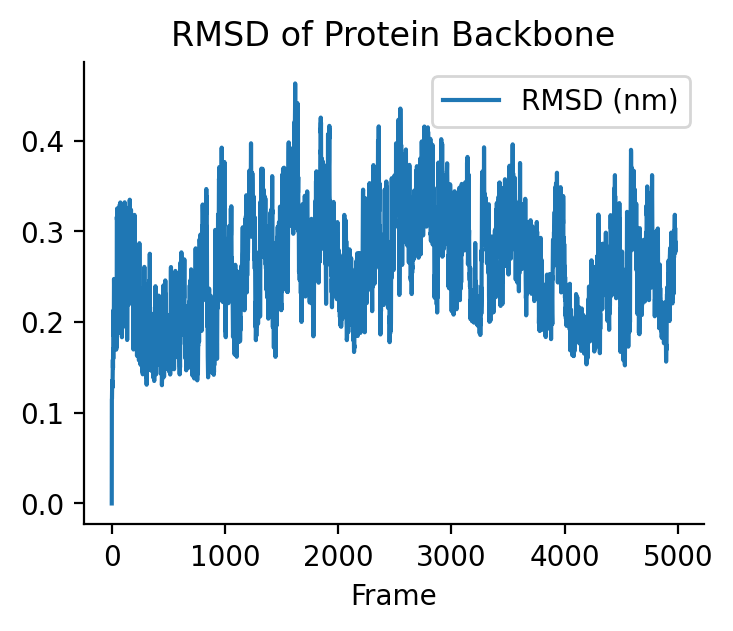

In [90]:
rmsd = compute_rmsd_on_specific_regions(traj1, 'backbone')
rmsd.plot(x='Frame', y='RMSD (nm)', figsize=(4, 3), title='RMSD of Protein Backbone')
sns.despine()

In [91]:
rmsd

,Frame,RMSD (nm)
0,0,0.000000
1,1,0.114869
2,2,0.115659
3,3,0.123118
4,4,0.135603
...,...,...
4974,4974,0.294611
4975,4975,0.275887
4976,4976,0.289610
4977,4977,0.277547


#### Now RMSF 

In [93]:
def compute_rmsf_on_specific_regions(traj: md.Trajectory, region: str | None ='backbone',
                                     parallel: bool = True, precentered: bool = False) -> pd.DataFrame:
    """
    Compute the root mean square fluctuation (RMSF) on specific regions of a trajectory.

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory object.
    region : str
        The selection string for atoms to include in the RMSF calculation.

    Returns
    -------
    rmsf_df: pandas.DataFrame
        A DataFrame containing the RMSF values for each frame in the trajectory.
    """
    if region:
        target = select_mdtraj_atoms(traj, region=region)
    else: 
        target = traj

    # Compute the RMSF
    rmsf = md.rmsf(target, target, frame = 0, parallel=parallel, precentered =precentered)

    return pd.DataFrame({'Frame': range(len(rmsf)), 'RMSF (nm)': rmsf})

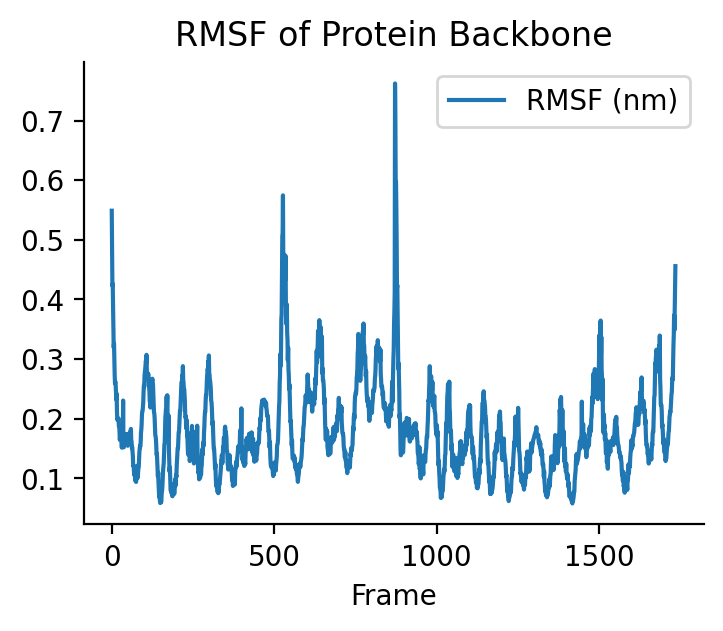

In [94]:
rmsf = compute_rmsf_on_specific_regions(traj1, 'backbone')
rmsf.plot(x='Frame', y='RMSF (nm)', figsize=(4, 3), title='RMSF of Protein Backbone')
sns.despine()



### Contacts 

In [96]:
distances, atom_pairs = md.compute_contacts(traj1[:T], contacts='all', scheme='closest-heavy', periodic=True)

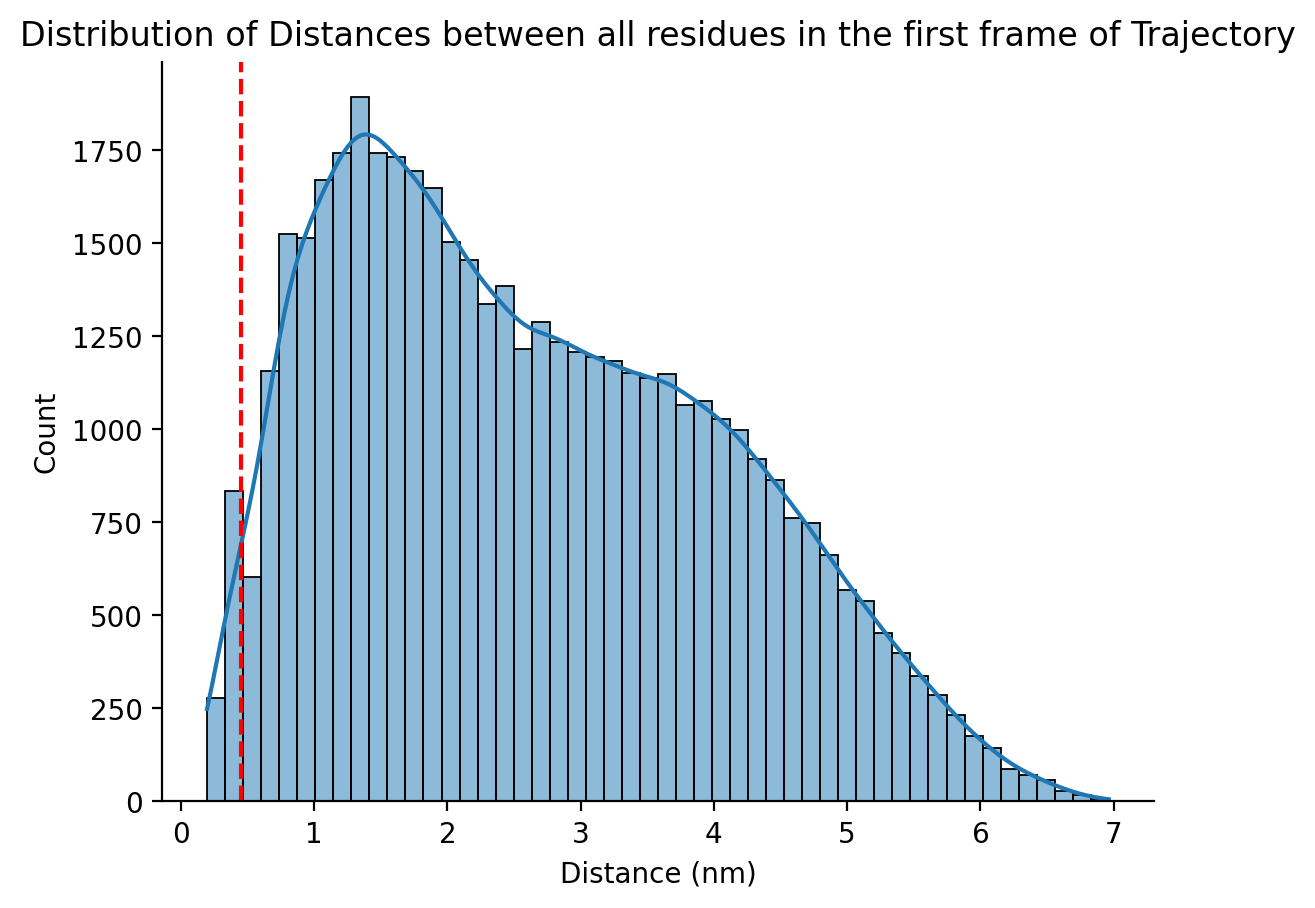

In [97]:
ax= sns.histplot(distances[0], bins=50, kde=True, alpha = 0.5)
ax.axvline(0.45, color='red', linestyle='--', label='0.45 nm threshold')
ax.set(xlabel='Distance (nm)', ylabel='Count',
       title='Distribution of Distances between all residues in the first frame of Trajectory')
sns.despine()


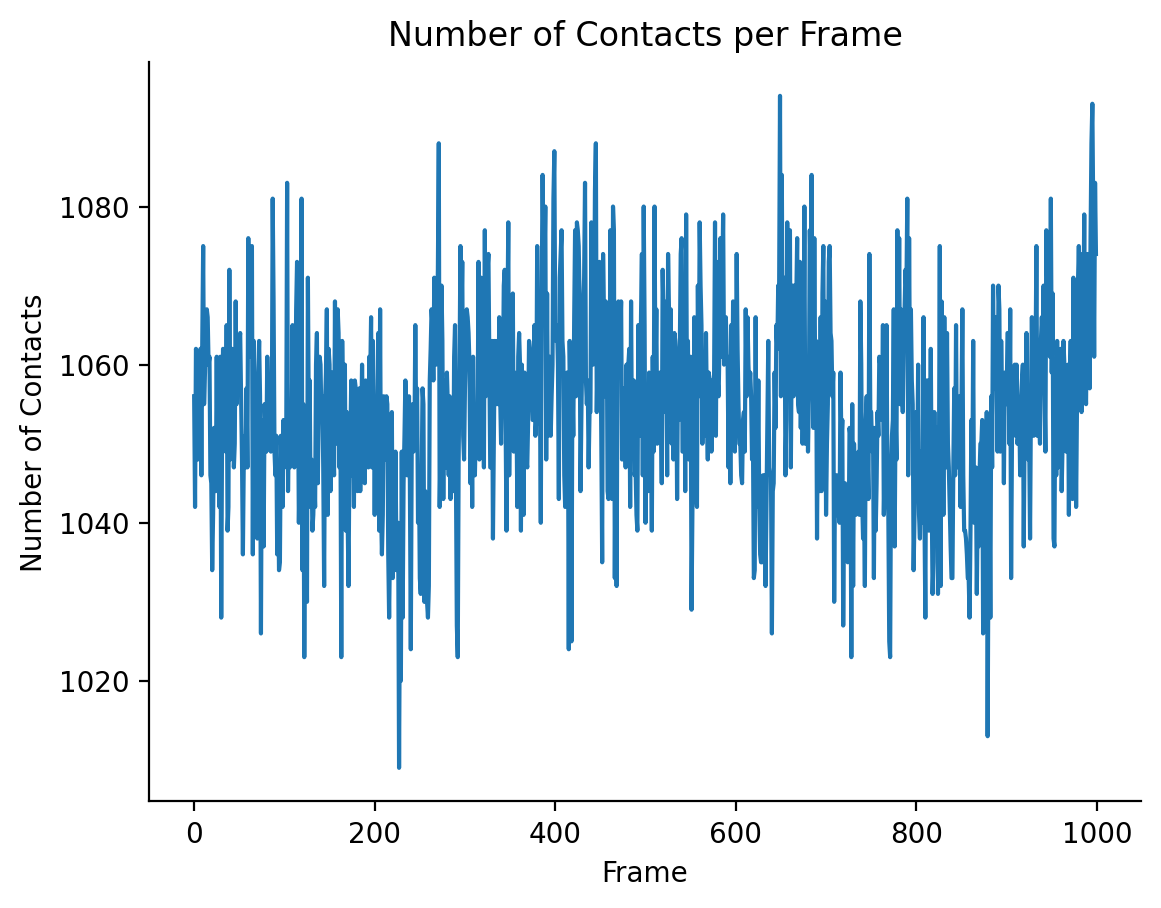

In [98]:
num_contacts_per_frame = (distances<=0.45).sum(axis=1)
plt.plot(num_contacts_per_frame)
plt.gca().set(xlabel='Frame', ylabel='Number of Contacts', title='Number of Contacts per Frame')
sns.despine()

In [99]:
def compute_contacts_on_specific_regions(traj: md.Trajectory, region: str | None = None, 
                                         cutoff: float = 0.45, contacts: str = 'all', 
                                         scheme: str = 'closest-heavy') -> tuple[pd.Series, np.ndarray, np.ndarray]:
    """
    Compute the number of contacts in a specific region of a trajectory.
    Args:
        traj (md.Trajectory): The trajectory object.
        region (str, optional): The selection string for atoms to include in the contact calculation.
            If None, all atoms will be included. Defaults to None.
        cutoff (float, optional): The distance cutoff for contacts in nanometers. Defaults to 0.45.
        contacts (str, optional): The type of contacts to compute. Defaults to 'all'.
        scheme (str, optional): The scheme for computing contacts. Defaults to 'closest-heavy'.
    Returns
        num_contacts (pd.Series): An array containing the number of contacts for each frame.
        distances (np.ndarray): An array containing the distances between atom pairs.
        atom_pairs (np.ndarray): An array containing the atom pairs involved in the contacts.
    """


    # Select atoms based on the specified region
    if region:
        traj = select_mdtraj_atoms(traj, region=region)
    else:
        traj = traj

    # Compute contacts for the selected region
    distances, atom_pairs = md.compute_contacts(traj, contacts=contacts, scheme=scheme, periodic=True)
    num_contacts = pd.Series((distances <= cutoff).sum(axis=1))

    return num_contacts, distances, atom_pairs 


In [102]:
num_contacts, distances, atom_pairs = compute_contacts_on_specific_regions(traj1[:T], region='protein', cutoff=0.45)

In [103]:
num_contacts.head()

0    1056
1    1042
2    1062
3    1061
4    1048
dtype: int64

In [104]:
distances

array([[0.5616233 , 1.0247176 , 1.2858194 , ..., 0.6887225 , 1.0153172 ,
        0.66338444],
       [0.6513929 , 1.0188392 , 1.2682647 , ..., 0.555192  , 0.94841105,
        0.652083  ],
       [0.7109654 , 1.0592884 , 1.3558723 , ..., 0.6210786 , 1.0428077 ,
        0.73321736],
       ...,
       [0.71030694, 1.0573858 , 1.1628969 , ..., 0.6758748 , 0.93233734,
        0.5239463 ],
       [0.65587527, 0.9887816 , 1.1161324 , ..., 0.6756205 , 0.96892047,
        0.48162684],
       [0.6538692 , 0.97878164, 1.0617805 , ..., 0.7127981 , 1.0217413 ,
        0.49780858]], shape=(1000, 46011), dtype=float32)

In [105]:
atom_pairs

array([[  0,   3],
       [  0,   4],
       [  0,   5],
       ...,
       [429, 432],
       [429, 433],
       [430, 433]], shape=(46011, 2))

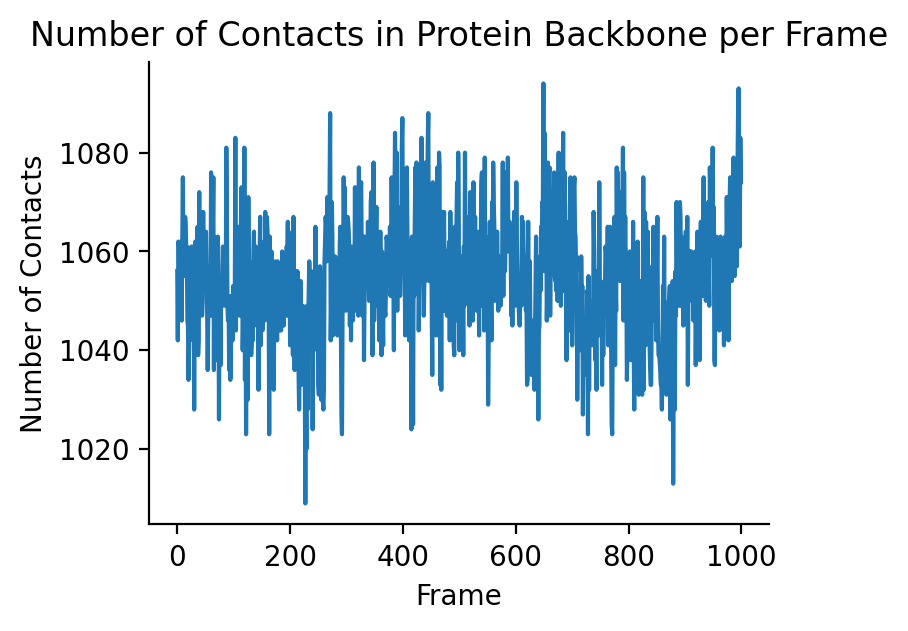

In [106]:
num_contacts.plot(kind='line', figsize=(4, 3), xlabel='Frame', ylabel='Number of Contacts',
                           title='Number of Contacts in Protein Backbone per Frame')
sns.despine()

### S2 N-H2 order parameter. 

This is a measure of the local order of the protein. It is often calculated as a function of the orientation autocorrelation function (OACF) of the N-H bond vector. The S2 order parameter is defined as:

$ S_2 = \frac{1}{2} \left( 3 \langle \cos^2 \theta \rangle - 1 \right) $

where $\theta$ represents the angle between the N-H bond vector and the z-axis of the local frame of reference. The S2 order parameter ranges from 0 to 1, where 0 indicates complete disorder and 1 indicates complete order.


We can use the pytraj function `pytraj.order_parameter` to compute the S2 order parameter. 



In [107]:
def identify_chains_from_pytraj_trajectory(traj: pt.Trajectory, chain_names: list[str] | None) -> list[int]:
    """
    Identify chains in a PyTraj trajectory.

    Parameters
    ----------
    traj : pytraj.Trajectory
        The trajectory object.
    chain_names : list[str] | None
        A list of chain names to identify. If None, all chains will be identified.

    Returns
    -------
    indices : list[int]
        A list of indices representing the start of each chain.
    """
    chains = {}
    if chain_names is None: 
        chain_names = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'.split()
    else: 
        chain_names.append('Other')
    chainid = 0
    chain_name = chain_names[chainid]
    chain = []
    for i, res in enumerate(traj.top.residues):
        first_atom = traj.top[res.first_atom_index]
        if first_atom.chain != chainid:
            chains[chain_name] = chain
            chainid += 1
            chain_name = chain_names[chainid]
            chain = []
        chain.append(i+1)  # +1 to convert from 0-based index to 1-based index

    chains[chain_name] = chain # add the last chain
    return chains


def select_chains(traj: pt.Trajectory, select_chains: list[str], chains:dict[str, list[int]] ) -> pt.Trajectory:
    """
    Select chains from a PyTraj trajectory.

    Parameters
    ----------
    traj : pytraj.Trajectory
        The trajectory object.
    select_chains : list[str]
        A list of chain names to select.
    chains : dict[str, list[int]]
        A dictionary mapping chain names to lists of residue indices.
        
    Returns
    -------
    pt.Trajectory
        A trajectory object containing the selected chains.
    """
    residues = []
    for chain in select_chains:
        if chain in chains:
            chain_residues = chains[chain]
            residues.append([chain_residues[0], chain_residues[-1]])  # select first and last residue of the chain
    residue_query = ':' + ','.join([f'{c[0]}-{c[1]}' for c in residues])
    return traj[residue_query]


In [108]:
ptraj = pt.load(str(dcd), top=str(psf))
nv.show_pytraj(ptraj)

NGLWidget(max_frame=4978)

In [109]:
chains = identify_chains_from_pytraj_trajectory(ptraj, chain_names=['Antigen', 'HC', 'LC'])
ptraj2 = select_chains(ptraj, select_chains=['HC', 'LC'], chains=chains)

In [110]:
n_residues = ptraj2.top.n_residues
H_mask = ':' + ','.join(str(i) for i in range(2, n_residues+1)) + '@HN'


In [111]:
h_indices = pt.select_atoms(ptraj2.top, H_mask)

# select N (backbone) indices
n_indices = h_indices - 1

# create pairs
nh_pairs = list(zip(n_indices, h_indices))
nh_pairs[:3]

[(np.int64(14), np.int64(15)),
 (np.int64(29), np.int64(30)),
 (np.int64(45), np.int64(46))]

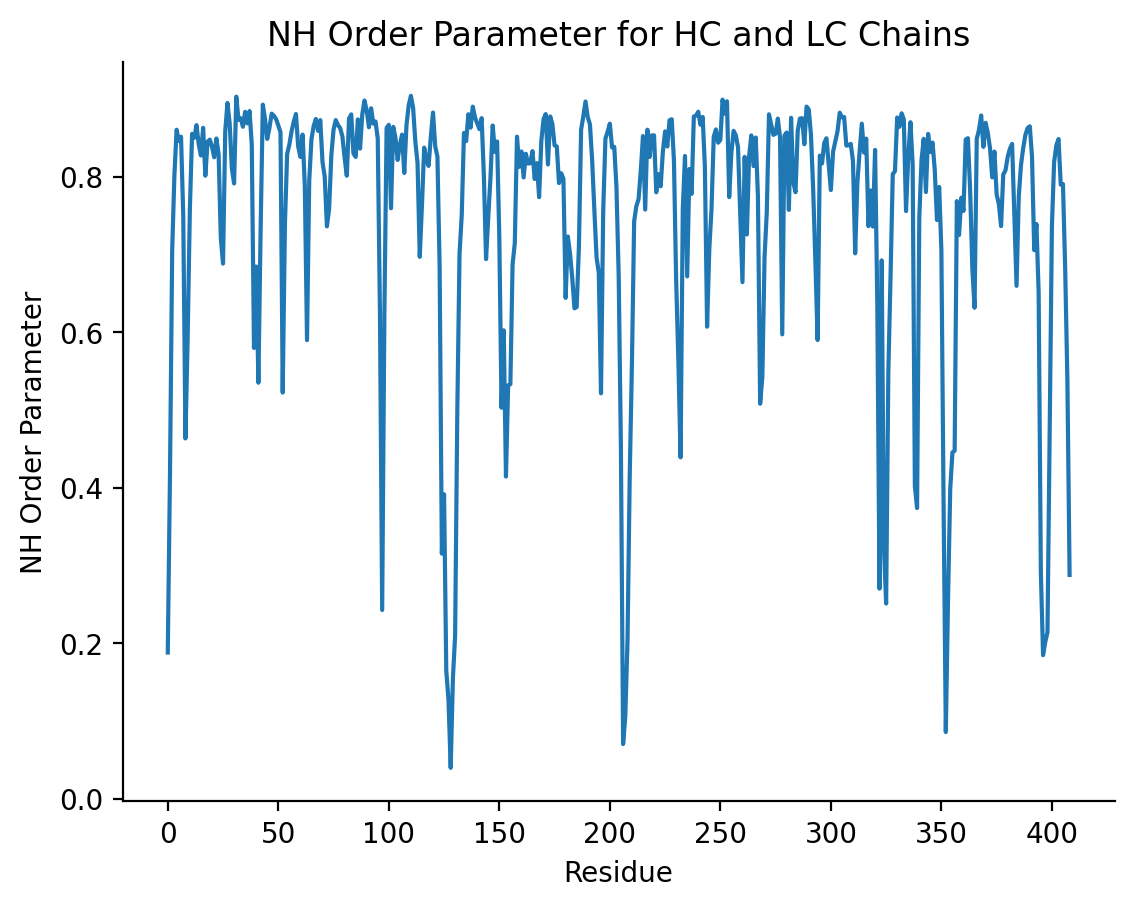

In [112]:
s2 = pt.NH_order_parameters(ptraj2, nh_pairs, tcorr=4000, tstep=1.0, n_cores=1)

plt.plot(s2)
plt.gca().set(xlabel='Residue', ylabel='NH Order Parameter',
               title='NH Order Parameter for HC and LC Chains')
sns.despine()

In [113]:
def calculate_s2_parameter(traj: pt.Trajectory, chains: list[str] | None = None,
                          chains_dict: dict[str, list[int]] | None = None,
                          tcorr: int = 4000, tstep: float = 1.0,
                          h_symbol: str='HN') -> pd.DataFrame:
    """
    Calculate the S2 order parameter for a trajectory.

    Parameters
    ----------
    traj : pytraj.Trajectory
        The trajectory object.
    chains : dict[str, list[int]] | None
        A dictionary mapping chain names to lists of residue indices.
        If None, all chains will be included.
    tcorr : int
        The correlation time in picoseconds.
    tstep : float
        The time step in nanoseconds.
    h_symbol : str
        The symbol for the hydrogen atom to use in the calculation.
        Default is 'HN' for backbone amide hydrogens.
        

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the S2 order parameter values for each residue.
    """
    if chains is not None and chains_dict is not None:
        traj = select_chains(traj, select_chains=chains, chains=chains_dict)

    n_residues = traj.top.n_residues
    H_mask = ':' + ','.join(str(i) for i in range(2, n_residues+1)) + f'@{h_symbol}'

    h_indices = pt.select_atoms(traj.top, H_mask)
    
    # select N (backbone) indices
    n_indices = h_indices - 1
    
    # create pairs
    nh_pairs = list(zip(n_indices, h_indices))
    
    s2 = pt.NH_order_parameters(traj, nh_pairs, tcorr=tcorr, tstep=tstep)
    
    return pd.DataFrame({'Residue': range(1, len(s2)+1), 'S2': s2})

In [114]:
s2 = calculate_s2_parameter(ptraj, chains=['HC', 'LC'], chains_dict=chains)

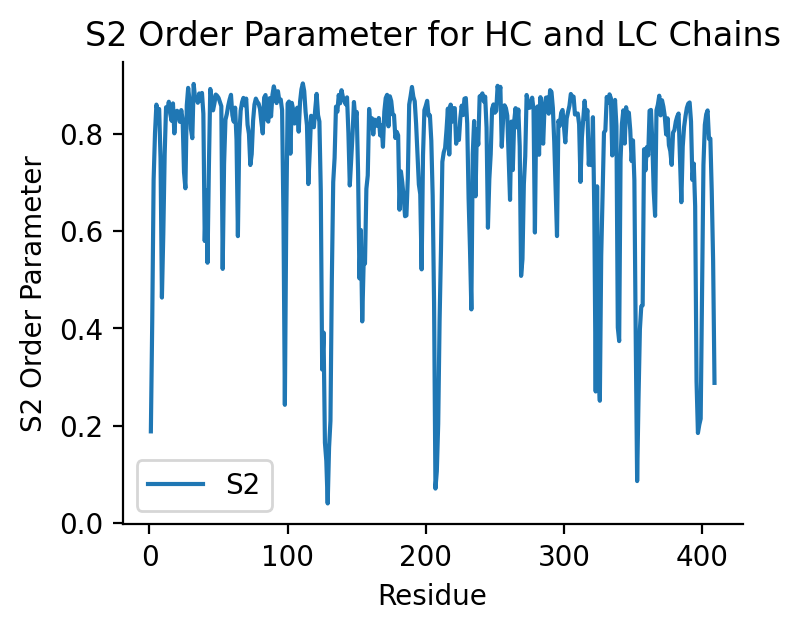

In [116]:
s2.plot(x='Residue', y='S2', figsize=(4, 3),
        title='S2 Order Parameter for HC and LC Chains',
        xlabel='Residue', ylabel='S2 Order Parameter')
sns.despine()